# Legge dei punti coniugati

I dati sono presi da un'esperienza di laboratorio per la verifica della legge dei punti coniugati in ottica geometrica.

La legge è la seguente:

$\displaystyle \frac{1}{p} + \frac{1}{q} = \frac{1}{f}$

Nell'esperienza vengono misurati diversi valori di $p$ ed i corrispondenti $q$ con lo scopo di misurare $f$, la distanza focale della lente. Si calcolano quindi gli inversi di $p$ e $q$ e si propagani i corrispondenti errori.

Si eseque quindi una regressione lineare sulle variabili $P=1/p$ e $Q=1/q$.

La presenza di errori, sia nella misura di $p$ (quindi di $P$) che di $q$ (quindi di $Q$), non è in genere contemplata nelle procedure di regressione lineare.

Tuttavia, si può propagare l'errore su $P$ in base alla funzione di *fit* ed ottenere un contributo ulteriore all'errore su $Q$. Il *fit* su può quindi iterare per ottenere una nuova stima, più accurata, con i suoi errori. La procedura iterativa si può ripetere fino ad ottenere un valore stabile dei parametri del fit.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
import numpy as np

In [7]:
df = pd.read_csv('data/lab_ottica_punti_coniugati.csv')

Le unità di misura sono cm

In [8]:
df

,p,q,dp,dq,Q,P,1/f,dQ,dP
0,32.0,57.5,0.5,0.5,0.017391,0.031250,0.048641,0.000151,0.000488
1,42.0,38.5,0.5,0.5,0.025974,0.023810,0.049784,0.000337,0.000283
2,52.5,33.0,0.5,0.5,0.030303,0.019048,0.049351,0.000459,0.000181
3,62.5,29.5,0.5,0.5,0.033898,0.016000,0.049898,0.000575,0.000128
4,71.5,28.0,0.5,0.5,0.035714,0.013986,0.049700,0.000638,0.000098
5,87.0,25.5,0.5,0.5,0.039216,0.011494,0.050710,0.000769,0.000066
6,95.0,25.0,0.5,0.5,0.040000,0.010526,0.050526,0.000800,0.000055
7,105.0,24.5,0.5,0.5,0.040816,0.009524,0.050340,0.000833,0.000045
8,119.0,23.5,0.5,0.5,0.042553,0.008403,0.050957,0.000905,0.000035
9,144.5,22.5,0.5,0.5,0.044444,0.006920,0.051365,0.000988,0.000024


Grafichiamo $p$ *vs* $q$. Va notato che a questo punto avremmo gli strumenti per fare un fit direttamente di questi dati secondo la legge:

$\displaystyle q(p) = \frac{1}{\displaystyle\frac{1}{f}-\frac{1}{p}}$

$f$ è il parametro da determinare nel fit.

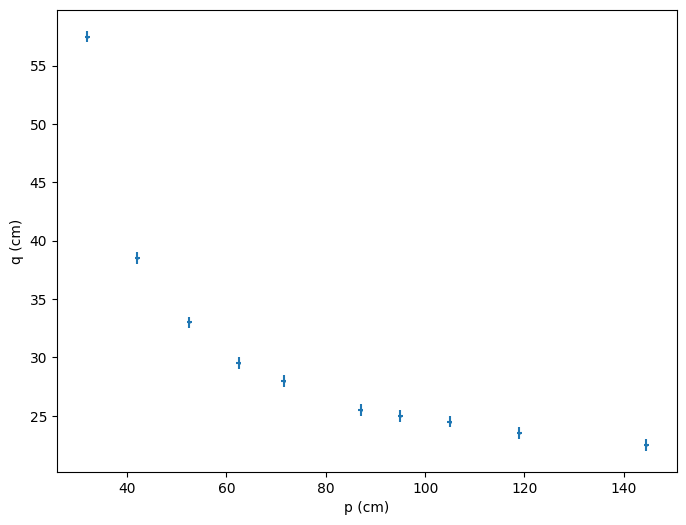

In [9]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.errorbar(df.p, df.q, xerr=df.dp, yerr=df.dq, marker='o', markersize=1, linestyle='')
ax.set_xlabel('p (cm)')
ax.set_ylabel('q (cm)')
fig.show()

Implementiamo un *fit* di minimo chi-quadro, dove possiamo aggiungere un possibile extra parametro $k$ al numeratore, che dovrebbe, nel fit, risultare vicino ad uno. Potrebbe rappresentare un fattore di scala da applicare alle misure di $q$:

$\displaystyle q(p) = \frac{k}{\displaystyle\frac{1}{f}-\frac{1}{p}}$

k = 0.918 ± 0.013
f = 21.167 ± 0.147
rho(k,f) = -0.94175


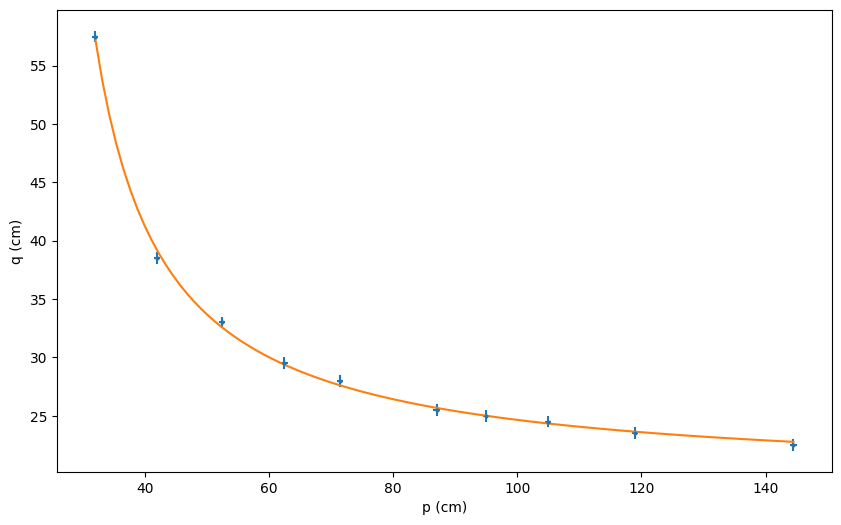

In [10]:
def model(p, k, f):
    return k/(1/f - 1/p)
par, cov = curve_fit(model, df.p, df.q, p0=[1, 1], sigma=df.dq, absolute_sigma=True)
err = [math.sqrt(cov[i, i]) for i in range(cov.shape[0])]
print('k = {:.3f} ± {:.3f}'.format(par[0], err[0]))
print('f = {:.3f} ± {:.3f}'.format(par[1], err[1]))
print('rho(k,f) = {:.5f}'.format(cov[0,1]/(err[0]*err[1])))

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(df.p, df.q, xerr=df.dp, yerr=df.dq, marker='o', markersize=2, linestyle='')
xs = np.linspace(df.p.values[0], df.p.values[-1], 100)
ax.plot(xs, model(xs, *par), label='fit line')
ax.set_xlabel('p (cm)')
ax.set_ylabel('q (cm)')
fig.show()

Aggiungiamo un possibile *offset* in $p$:

$\displaystyle q(p) = \frac{k}{\displaystyle\frac{1}{f}-\frac{1}{p-p_0}}$

$p_0$ dovrebbe risultare, nel fit, vicino a zero:

k = 0.933 ± 0.103
f = 20.881 ± 1.847
p0 = 0.387 ± 2.486
rho(k,f) = -0.99795
rho(k,p0) = 0.99126
rho(f,p0) = -0.99692


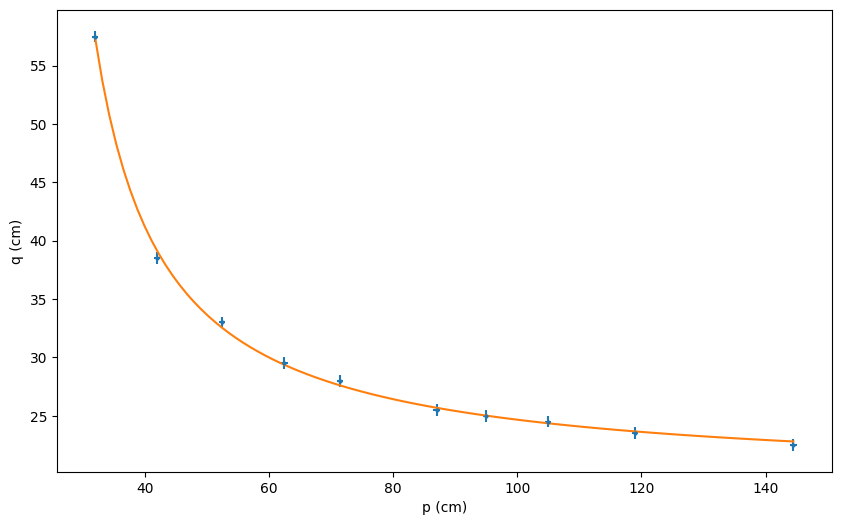

In [11]:
def model(p, k, f, p0):
    return k/(1/f - 1/(p-p0))
par, cov = curve_fit(model, df.p, df.q, p0=[1, 20, 0], sigma=df.dq, absolute_sigma=True)
err = [math.sqrt(cov[i,i]) for i in range(3)]
print('k = {:.3f} ± {:.3f}'.format(par[0], err[0]))
print('f = {:.3f} ± {:.3f}'.format(par[1], err[1]))
print('p0 = {:.3f} ± {:.3f}'.format(par[2], err[2]))
print('rho(k,f) = {:.5f}'.format(cov[0,1]/(err[0]*err[1])))
print('rho(k,p0) = {:.5f}'.format(cov[0,2]/(err[0]*err[2])))
print('rho(f,p0) = {:.5f}'.format(cov[1,2]/(err[1]*err[2])))
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(df.p, df.q, xerr=df.dp, yerr=df.dq, marker='o', markersize=2, linestyle='')
xs = np.linspace(df.p.values[0], df.p.values[-1], 100)
ax.plot(xs, model(xs, *par), label='fit line')
ax.set_xlabel('p (cm)')
ax.set_ylabel('q (cm)')
fig.show()

Aggiungiamo un possibile *offset* in $q$:

$\displaystyle q(p) = \frac{k}{\displaystyle\frac{1}{f}-\frac{1}{p}} + q_0$

$q_0$ dovrebbe risultare, nel fit, vicino a zero:

k = 0.900 ± 0.116
f = 21.268 ± 0.660
q0 = 0.355 ± 2.275
rho(k,f) = -0.99249
rho(k,q0) = -0.99357
rho(f,q0) = 0.97516


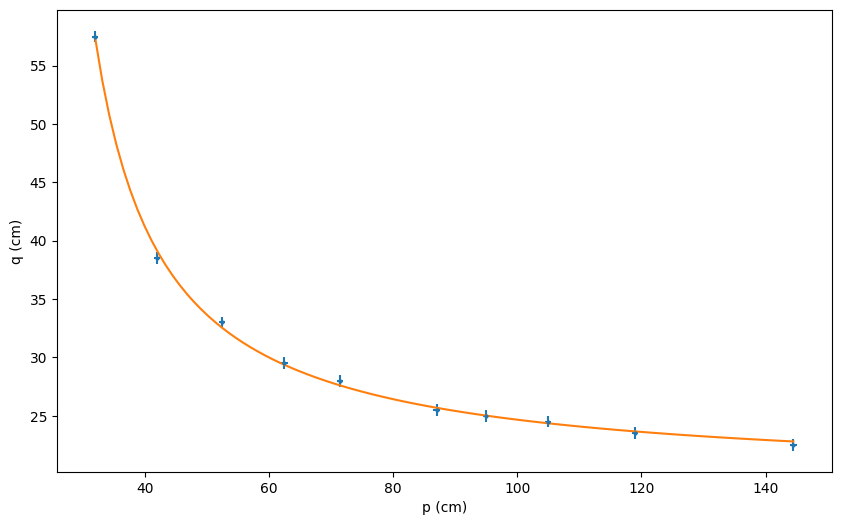

In [12]:
def model(p, k, f, q0):
    return k/(1/f - 1/p)+q0
par, cov = curve_fit(model, df.p, df.q, p0=[1, 20, 0], sigma=df.dq, absolute_sigma=True)
err = [math.sqrt(cov[i,i]) for i in range(3)]
print('k = {:.3f} ± {:.3f}'.format(par[0], math.sqrt(cov[0,0])))
print('f = {:.3f} ± {:.3f}'.format(par[1], math.sqrt(cov[1,1])))
print('q0 = {:.3f} ± {:.3f}'.format(par[2], math.sqrt(cov[2,2])))
print('rho(k,f) = {:.5f}'.format(cov[0,1]/(err[0]*err[1])))
print('rho(k,q0) = {:.5f}'.format(cov[0,2]/(err[0]*err[2])))
print('rho(f,q0) = {:.5f}'.format(cov[1,2]/(err[1]*err[2])))
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(df.p, df.q, xerr=df.dp, yerr=df.dq, marker='o', markersize=2, linestyle='')
xs = np.linspace(df.p.values[0], df.p.values[-1], 100)
ax.plot(xs, model(xs, *par), label='fit line')
ax.set_xlabel('p (cm)')
ax.set_ylabel('q (cm)')
fig.show()

se aggiungo sia $q_0$ che $p_0$ ho problemi di convergenza che si possono evidenziare con l'opzione ```full_output=True```, che restituisce anche eventuali messaggio di errore:

$\displaystyle q(p) = \frac{k}{\displaystyle\frac{1}{f}-\frac{1}{p-p_0}} + q_0$

I valori degli errori sono evidentemente poco sensati.

Error: Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
k = 0.950 ± 42859.854
f = 20.694 ± 466485.830
p0 = 0.573 ± 466485.837
q0 = -0.175 ± 443421.832
rho(k,f) = -1.0000000000
rho(k,p0) = 1.0000000000
rho(k,q0) = -1.0000000000
rho(f,p0) = -1.0000000000
rho(f,q0) = 1.0000000000
rho(p0,q0) = -1.0000000000


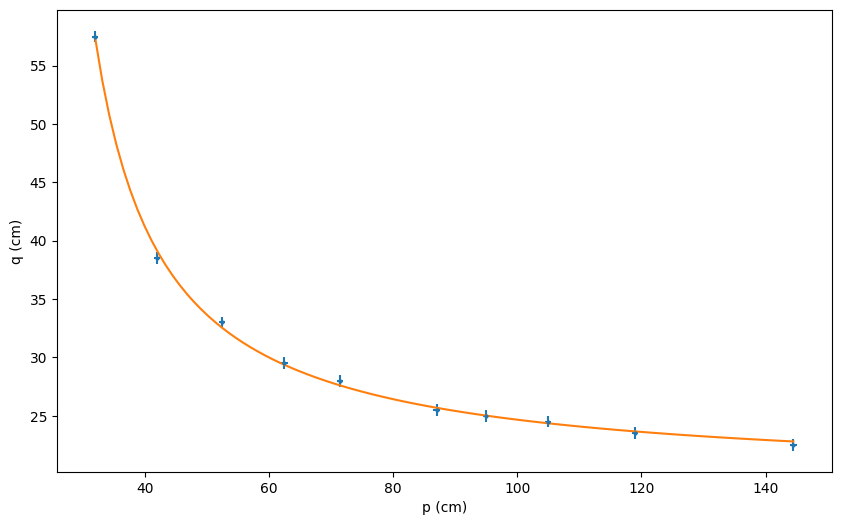

In [13]:
def model(p, k, f, p0, q0):
    return k/(1/f - 1/(p-p0))+q0
par, cov, info, errmsg, ier = curve_fit(model, df.p, df.q, p0=[0.8, 21, 0.3, 0.3], sigma=df.dq,
                                        absolute_sigma=True, full_output=True)
if ier == 1:
    print("Error: " + errmsg)
err = [math.sqrt(cov[i, i]) for i in range(4)]
print('k = {:.3f} ± {:.3f}'.format(par[0], err[0]))
print('f = {:.3f} ± {:.3f}'.format(par[1], err[1]))
print('p0 = {:.3f} ± {:.3f}'.format(par[2], err[2]))
print('q0 = {:.3f} ± {:.3f}'.format(par[3], err[3]))
print('rho(k,f) = {:.10f}'.format(cov[0,1]/(err[0]*err[1])))
print('rho(k,p0) = {:.10f}'.format(cov[0,2]/(err[0]*err[2])))
print('rho(k,q0) = {:.10f}'.format(cov[0,3]/(err[0]*err[3])))
print('rho(f,p0) = {:.10f}'.format(cov[1,2]/(err[1]*err[2])))
print('rho(f,q0) = {:.10f}'.format(cov[1,3]/(err[1]*err[3])))
print('rho(p0,q0) = {:.10f}'.format(cov[2,3]/(err[2]*err[3])))
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(df.p, df.q, xerr=df.dp, yerr=df.dq, marker='o', markersize=2, linestyle='')
xs = np.linspace(df.p.values[0], df.p.values[-1], 100)
ax.plot(xs, model(xs, *par), label='fit line')
ax.set_xlabel('p (cm)')
ax.set_ylabel('q (cm)')
fig.show()

Va notato che gli errori $\pm 0.5$ sono errori **massimi**, mentre l'errore statistico corretto dovrebbe essere $\sigma = 1\mathrm{mm} /\sqrt{12}\simeq 0.29mm$. Quindi, gli errori di $\pm 0.5\mathrm{mm}$ sono sovrastimati di un fattore $0.58$, così come tutti gli errori dei fit.

Dimostreremo che l'espressione è sovradeterminata, e i quattro parametri non sono tutti indipendenti:

$\displaystyle q(p) = \frac{k}{\displaystyle\frac{1}{f}-\frac{1}{p-p_0}} + q_0 =
\frac{kf(p-p_0)}{p-p_0-f} + q_0$

La funzione ha un asintoto verticale per $p = p_0+f$. In termini di un nuovo parametro, $p_a = p_0 +f$, possiamo scrivere:


$\displaystyle q(p) = \frac{kf(p-p_a+f)}{p-p_a} + q_0 = kf+ q_0 + \frac{kf^2}{p-p_a}$

Se definisco $q_a = q_0 + kf$ e $h = kf^2$, ho:

$\displaystyle q(p) = q_a + \frac{h}{p-p_a}$

Sono sufficienti quindi tre parametri indipendenti per determinare la funzione:

$\displaystyle\left\{\begin{array}{rl}
p_a & = p_0 + f  \\
q_a & = q_0 + kf \\
h & = kf^2
\end{array}\right.
$

La parametrizzazione con quattro parametri è quindi sovradeterminata. La conseguenza è che 
il fit non ha un solo minimo, ma, nello spazio a quattro parametri $(p_0, q_0, f, k)$, ha
valore minimo nel luogo dei punti che soddisfano il sistema di equazioni:

$\displaystyle\left\{\begin{array}{rl}
\widehat{p_a} & = p_0 + f  \\
\widehat{q_a} & = q_0 + kf \\
\hat{h} & = kf^2
\end{array}\right.
$

Come conseguenza, la matrice hessiana:

$\displaystyle C_{ij}^{-1} =-\frac{\partial^2 \log(p(x_i,\cdots,x_n; \mu_i, \cdots, \mu_n))}{\partial\mu_i\,\partial\mu_j}
$

risulta degenere, e ci sono elementi con coefficiente di correlazione $\rho = \pm 1$.

La parametrizzazione più sensata con tre parametri probabilmente, è:

$\displaystyle q(p) = \frac{1}{\displaystyle\frac{1}{f}-\frac{1}{p-p_0}} + q_0$

Infatti, questo tiene conto di possibili effetti sistematici dello "zero" delle misure di $p$ e di $q$, senza alterare la legge dei punti coniugati originale!

Come si può vedere, il risultato è quello più vicino a quello nominale, $f=20$.

**Nota:** usando l'opzione ```absolute_sigma=False``` si ottiene un errore ancora più piccolo. È più chiaro il significato di questo approccio in un notebook separato.

f = 20.174 ± 0.680
p0 = 1.094 ± 1.331
q0 = -0.683 ± 1.096
rho(f,p0) = -0.99328
rho(f,q0) = -0.98640
rho(p,q0) = 0.97066


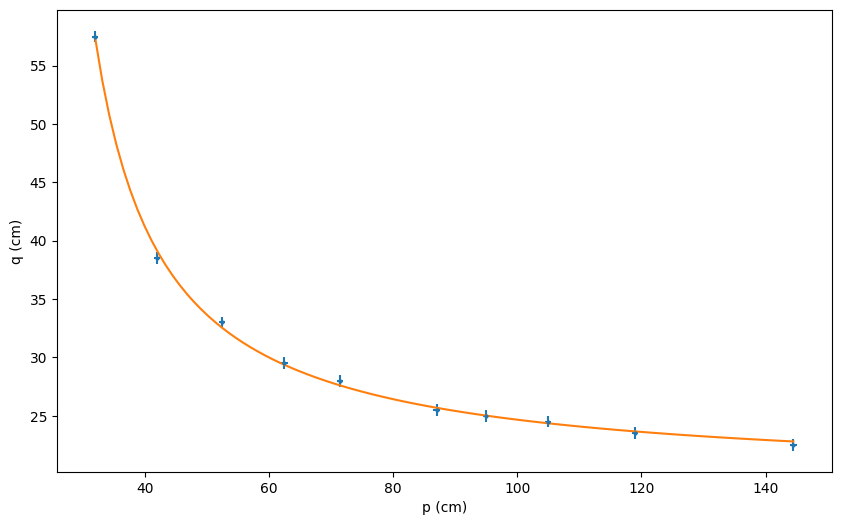

In [14]:
def model(p, f, p0, q0):
    return 1/(1/f - 1/(p-p0)) + q0
par, cov = curve_fit(model, df.p, df.q, p0=[20, 0, 0], sigma=df.dq, absolute_sigma=True)
err = [math.sqrt(cov[i,i]) for i in range(3)]
print('f = {:.3f} ± {:.3f}'.format(par[0], math.sqrt(cov[0,0])))
print('p0 = {:.3f} ± {:.3f}'.format(par[1], math.sqrt(cov[1,1])))
print('q0 = {:.3f} ± {:.3f}'.format(par[2], math.sqrt(cov[2,2])))
print('rho(f,p0) = {:.5f}'.format(cov[0,1]/(err[0]*err[1])))
print('rho(f,q0) = {:.5f}'.format(cov[0,2]/(err[0]*err[2])))
print('rho(p,q0) = {:.5f}'.format(cov[1,2]/(err[1]*err[2])))
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(df.p, df.q, xerr=df.dp, yerr=df.dq, marker='o', markersize=2, linestyle='')
xs = np.linspace(df.p.values[0], df.p.values[-1], 100)
ax.plot(xs, model(xs, *par), label='fit line')
ax.set_xlabel('p (cm)')
ax.set_ylabel('q (cm)')
fig.show()

## Fit lineare con gli inversi di $p$ e $q$

Passiamo quindi agli inversi, $1/p$ e $1/q$. Un fit lineare è sicuramente più semplice da implementare anche con strumenti software non troppo complessi.

**Nota:** con questa semplificazione non è facile recuperare i parametri $p_0$ e $q_0$ che abbiamo introdotto sopra.

Quindi una stima più corretta di $f$ è $f= 20.17 \pm 0.40$.

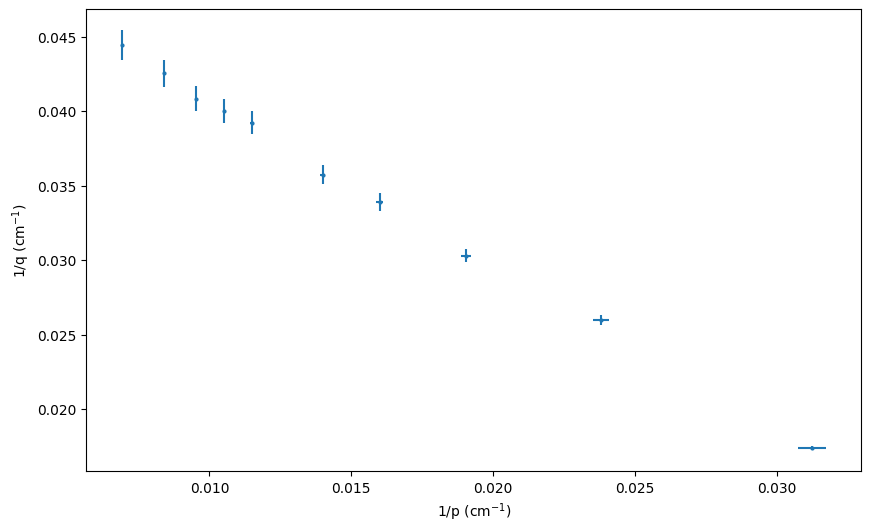

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(df.P, df.Q, xerr=df.dP, yerr=df.dQ, marker='o', markersize=2, linestyle='')
ax.set_xlabel('1/p (cm$^{-1}$)')
ax.set_ylabel('1/q (cm$^{-1}$)')
fig.show()

Procediamo con la regressione lineare. Potremmo anche usare una funzione python opportuna.

In [16]:
def model(P, a, b):
    return a + b*P
par, cov = curve_fit(model, df.P, df.Q, p0=[0.05, -1], sigma=df.dQ, absolute_sigma=True)

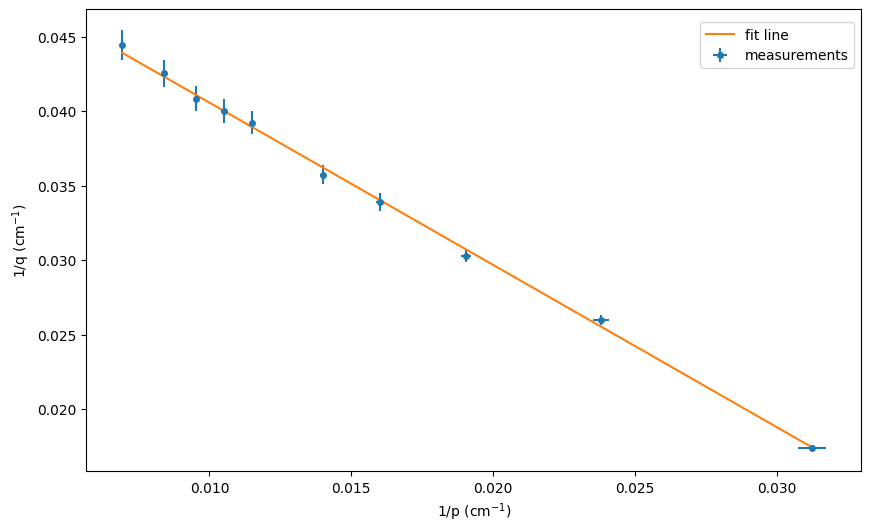

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(df.P, df.Q, xerr=df.dP, yerr=df.dQ, marker='o', markersize=4, linestyle='', label='measurements')
ax.plot(df.P, model(df.P, *par), label='fit line')
ax.set_xlabel('1/p ($\mathrm{cm}^{-1}$)')
ax.set_ylabel('1/q ($\mathrm{cm}^{-1}$)')
fig.legend(bbox_to_anchor=(0.9, 0.87))
fig.show()

Determiniamo i parametri del fit con i loro errori.

In [18]:
a, b = par[0], par[1]
err_a, err_b = math.sqrt(cov[0,0]), math.sqrt(cov[0,0])
cov_ab = cov[0, 1]
print('b = {:.3f} ± {:.3f}'.format(b, err_b))
print('a = {:.5f} ± {:.5f}'.format(a, err_a))
print('cov(a,b) = {:.8f}'.format(cov_ab))

b = -1.089 ± 0.000
a = 0.05145 ± 0.00043
cov(a,b) = -0.00000650


## Propagazione degli errori su $x$

Un modo per propagare gli errori su $x$ è di stimare, una volta ottenuto il fit, l'effetto su $y$, e sommare questo contributo all'errore su $y$:

$\displaystyle \delta y^\prime = \left|\frac{\mathrm{d}}{\mathrm{d}x}(a+bx)\right|\delta x = \left|b\right|\delta x$

$\displaystyle \delta y^{\mathrm{tot}} = \sqrt{\delta y^2 + b^2\delta x^2}$

Si può quindi rifare il fit, ed eventualmente procedere iterativamente fino che la procedura non converge.

<span style="color:red">Strettamente parlando, dovremmo anche propagare gli errori su $a$ e su $b$. Ma, se facessimo questo, gli errori sulle $y_i$ potranno avere un termine di correlazione tra di loro dovuto al termine di covarianza tra $a$ e $b$. Tenerne conto richiederebbe una ridefinizione del $\chi^2$ da minimizzare per ottenere le nuove stime di $a$ e di $b$. Ignoriamo questi errori per semplicità di calcolo, ma anche perché sono molto più piccoli degli errori su $x_i$ e $y_i$.</span>

Vedremo che in realtà bastano una o due iterazioni per far convergere il processo. In questo caso, i risultati cambiano pochissimo rispetto al fit originale. Ma non è detto che sia sempre così.

<span style="color:blue">Quando si aggiorna un fit fatto con una stima iniziale aggiungendo nuove informazioni, si parla di *refit*. Esistono diverse applicazioni, anche complesse, in cui questo può essere necessario. Ad esempio, in un rivelatore si può fare prima la ricostruzione delle tracce di alcune particelle. Quindi si calcolano fattori di calibrazione degli allineamenti relativi di diversi rivelatori. Si fa quindi il *refit* delle tracce ricostruite per tener conto del migiore allineamento e si ottengono in genere parametri delle tracce più accurati.</span>

In [19]:
niter = 4
a, b = 0, 0
for i in range(niter):
    err = np.sqrt(np.array(df.dQ.values)**2+(b*np.array(df.dP.values))**2)
    par, cov = curve_fit(model, df.P, df.Q, p0=[0.05, -1], sigma=err, absolute_sigma=True)
    a, b = par[0], par[1]
    err_a, err_b = math.sqrt(cov[0,0]), math.sqrt(cov[0,0])
    cov_ab = cov[0, 1]
    print('--- iter: {:d} ---'.format(i+1))
    print('b = {:.5f} ± {:.5f}'.format(b, err_b))
    print('a = {:.5f} ± {:.5f}'.format(a, err_a))
    print('cov(a,b) = {:.8f}'.format(cov_ab))


--- iter: 1 ---
b = -1.08895 ± 0.00043
a = 0.05145 ± 0.00043
cov(a,b) = -0.00000650
--- iter: 2 ---
b = -1.08416 ± 0.00054
a = 0.05136 ± 0.00054
cov(a,b) = -0.00001404
--- iter: 3 ---
b = -1.08415 ± 0.00054
a = 0.05136 ± 0.00054
cov(a,b) = -0.00001400
--- iter: 4 ---
b = -1.08415 ± 0.00054
a = 0.05136 ± 0.00054
cov(a,b) = -0.00001400


 È possibile iterare la procedura fino a che la stima converga ad un valore stabile.
 In questo esempio, la modifica dovuta agli errori sulle misure $x_i$ è abbastanza piccola.
 
Resta la limitata applicabilità di questo metodo, perché non sempre è possibile linearizzare il nostro modello. Ad esempio, l'introduzione dei parametri $p_0$ e $q_0$ considerata sopra già rende inutilizzabile questa semplificazione.